# Data Binning

The purpose of this notebook is to read in potential training data and characterize the physical attributes that are being trained on.

Primarily, this will be accomplished here by binning the data's:
- $r_s$ values, i.e. a measure of density representation
- $s$ values, i.e. a measure of the density gradient representation
- $\alpha$ values, i.e. a measure of the second derivative of the density

In [1]:
import torch
import numpy as np
from scipy.signal import correlate2d
from opt_einsum import contract
import os
import seaborn as sns
import colorsys
from ase.io import read, write
from ase import Atoms
from dpyscfl.utils import ase_atoms_to_mol, gen_mf_mol
import pyscf
from pyscf import gto,dft,scf
import matplotlib.pyplot as plt

In [2]:
def get_rs(rho):
    return (4*pi*rho/3)**(1/3)

def get_s(rho, drho):
    pref = 1/(2*(3*pi**2)**(1/3))
    kg = drho/(rho+1e-10)
    return pref*kg/rho

def get_alpha(rho, drho, tau):
    uniform_factor = (3/10)*(3*np.pi**2)**(2/3)
    tau_unif = uniform_factor*rho**(5/3)
    tau_w = (drho**2)/(8*rho)

def gen_cmap_values(cmaps, npercmap):
    cols = []
    c = []
    for icm in cmaps:
        cm = plt.get_cmap(icm)
        col = cm(np.linspace(0.2, 0.8, npercmap))
        cols.append(col)
    for i in range(npercmap):
        for ic, _ in enumerate(cols):
            c.append(cols[ic][i])
    return c

def get_N_cols(N=5):

    HSV_tuples = [(x*1.0/N, 1,1) for x in range(N)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    return RGB_tuples    

    
#spins for single atoms, since pyscf doesn't guess this correctly.
spins_dict = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}

def get_spin(at):
    #if single atom and spin is not specified in at.info dictionary, use spins_dict
    if ( (len(at.positions) == 1) and not ('spin' in at.info) ):
        spin = spins_dict[str(at.symbols)]
    else:
        if at.info.get('spin', None):
            print('Spin specified in atom info.')
            spin = at.info['spin']
        elif 'radical' in at.info.get('name', ''):
            print('Radical specified in atom.info["name"], assuming spin 1.')
            spin = 1
        elif at.info.get('openshell', None):
            print("Openshell specified in atom info, attempting spin 2.")
            spin = 2
        else:
            print("No specifications in atom info to help, assuming no spin.")
            spin = 0
    return spin

    
def get_rho(mf, mol, dm, grids):
    """Generates density on a grid provided
    Taken directly from dpyscfl.utils

    .. todo:: Make sure this is still how it works in dpyscf-lite

    Args:
        mf (pyscf kernel): PREVIOUSLY RUN kernel
        mol (:class:`pyscf.GTO.Mol`): molecule whose atomic orbitals generate rho
        dm (np.array): density matrix
        grids (_type_): _description_

    Returns:
        np.array: density on provided grid
    """
    print("Evaluating atomic orbitals on grid.")
    ao_eval = mf._numint.eval_ao(mol, grids.coords)
    print("AO Shape: {}. DM Shape: {}".format(ao_eval.shape, dm.shape))
    print("Evaluating density on grid.")
    rho = mf._numint.eval_rho(mol, ao_eval, dm, verbose=3)
    return ao_eval, rho
    
    
def rho_to_params(ao_eval, dm, level=0):
    '''
    Taken from dpyscfl.net
    '''
    if ao_eval.dim()==2:
        ao_eval = ao_eval.unsqueeze(0)
    else:
        ao_eval = ao_eval

    # Create density (and gradients) from atomic orbitals evaluated on grid
    # and density matrix
    # rho[ijsp]: del_i phi del_j phi dm (s: spin, p: grid point index)
    #print("FORWARD PASS IN XC. AO_EVAL SHAPE, DM SHAPE: ", ao_eval.shape, dm.shape)
    rho = contract('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    # Non-local electrostatic potential
    if level > 3:
        non_loc = contract('mnQ, QP, Pki, ...mn-> ...ki', self.df_3c, self.df_2c_inv, self.vh_on_grid, dm)
    else:
        non_loc = torch.zeros_like(tau).unsqueeze(-1)

    if dm.dim() == 3: # If unrestricted (open-shell) calculation

        # Density
        rho0_a = rho0[0]
        rho0_b = rho0[1]

        # Contracted density gradient
        gamma_a, gamma_b = contract('ij,ij->j',drho[:,0],drho[:,0]), contract('ij,ij->j',drho[:,1],drho[:,1])
        gamma_ab = contract('ij,ij->j',drho[:,0],drho[:,1])

        # Kinetic energy density
        tau_a, tau_b = tau

        # E.-static
        non_loc_a, non_loc_b = non_loc
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= contract('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
        non_loc_a=non_loc_b = non_loc*0.5

    tup1 = (rho0, drho, tau)
    tup2 = (rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b)

    return [tup1, tup2]

# Density (rho)
def l_1(rho):
    """Level 1 Descriptor -- Creates dimensionless quantity from rho.
    Eq. 3 in `base paper <https://link.aps.org/doi/10.1103/PhysRevB.104.L161109>`_

    .. math:: x_0 = \\rho^{1/3}

    Args:
        rho (torch.Tensor): density

    Returns:
        torch.Tensor: dimensionless density
    """
    return rho**(1/3)

# Reduced density gradient s
def l_2(rho, gamma, epsilon=1e-10):
    """Level 2 Descriptor -- Reduced gradient density
    Eq. 5 in `base paper <https://link.aps.org/doi/10.1103/PhysRevB.104.L161109>`_

    .. math:: x_2=s=\\frac{1}{2(3\\pi^2)^{1/3}} \\frac{|\\nabla \\rho|}{\\rho^{4/3}}

    Args:
        rho (torch.Tensor): density
        gamma (torch.Tensor): squared density gradient

    Returns:
        torch.Tensor: reduced density gradient s
    """
    return torch.sqrt(gamma)/(2*(3*np.pi**2)**(1/3)*rho**(4/3)+epsilon)

# Reduced kinetic energy density alpha
def l_3(rho, gamma, tau, epsilon=1e-10):
    """Level 3 Descriptor -- Reduced kinetic energy density
    Eq. 6 in `base paper <https://link.aps.org/doi/10.1103/PhysRevB.104.L161109>`_

    .. math:: x_3 = \\alpha = \\frac{\\tau-\\tau^W}{\\tau^{unif}},

    where

    .. math:: \\tau^W = \\frac{|\\nabla \\rho|^2}{8\\rho}, \\tau^{unif} = \\frac{3}{10} (3\\pi^2)^{2/3}\\rho^{5/3}.

    Args:
        rho (torch.Tensor): density
        gamma (torch.Tensor): squared density gradient
        tau (torch.Tensor): kinetic energy density

    Returns:
        torch.Tensor: reduced kinetic energy density
    """
    uniform_factor = (3/10)*(3*np.pi**2)**(2/3)
    tw = gamma/(8*(rho+epsilon))
    #commented is dpyscflite version, uncommented is xcdiff version
    #shouldn't change anything, but
    #return torch.nn.functional.relu((tau - tw)/(uniform_factor*rho**(5/3)+tw*1e-3 + 1e-12))
    return (tau - gamma/(8*(rho+epsilon)))/(uniform_factor*rho**(5/3)+epsilon)

def gen_desc(basepath, traj, dmsuff, pol=True):
    trj = read(os.path.join(basepath, traj), ':')
    desc = {}
    syms = []
    print("Generating descriptors on grid.")
    for idx, at in enumerate(trj):
        ipre = '{}_{}'.format(idx, at.symbols)
        syms.append(ipre)
        print('==============================')
        print(ipre)
        print('==============================')
        spin = get_spin(at)
        molgen = False
        scount = 0
        while not molgen:
            try:
                iname, imol = ase_atoms_to_mol(at, spin=spin, charge=at.info.get('charge', 0))
                molgen=True
            except RuntimeError:
                #spin disparity somehow, try with one less until 0
                print("RuntimeError. Trying with reduced spin.")
                spin = get_spin(at)
                spin = spin - scount - 1
                scount += 1
                if spin < 0:
                    raise ValueError
        idm = np.load(os.path.join(basepath, ipre+dmsuff))
        imf, imethod = gen_mf_mol(imol, xc='scan', pol=pol, grid_level=5)
        iao = imf._numint.eval_ao(imol, imf.grids.coords, deriv=2)
        if (imol.spin != 0) or (pol):
            print("Generating spin-channel densities.")
            _, irho_a = get_rho(imf, imol, idm[0], imf.grids)
            _, irho_b = get_rho(imf, imol, idm[1], imf.grids)
            irho = np.stack([irho_a,irho_b],axis=0)
        else:
            print("Generating non-polarized density.")
            irho = get_rho(mf, mol_ref, dm_init, mf.grids)

        iao = torch.from_numpy(iao)
        idm = torch.from_numpy(idm)
        print(iao.shape, idm.shape)
        print(iao.dim(), idm.dim())
        tup1, tup2 = rho_to_params(iao, idm)
        rho, drho, tau = tup1
        rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b = tup2
        l1 = l_1(rho0_a+rho0_b)
        l2 = l_2(rho0_a + rho0_b, gamma_a+gamma_b+2*gamma_ab)
        l3 = l_3(rho0_a + rho0_b, gamma_a+gamma_b+2*gamma_ab, tau_a+tau_b)

        desc[ipre] = [l1, l2, l3]
        print("Descriptor generation complete.")
    return desc, syms


def hist_params(basepath, traj, cols, dmsuff='.dm.npy', pol=True, log=True, nbins=200, **kwargs):
    
    print("Generating descriptors on grid.")
    desc, syms = kwargs.get('desc', None) if kwargs.get('desc', None) else gen_desc(basepath, traj, dmsuff, pol)
    print("Descriptor generation complete.")
    print("Finding max descriptor values for binning range.")
    l1mx = -999999
    l2mx = -999999
    l3mx = -999999
    
    l1mn = -1*l1mx
    l2mn = -1*l2mx
    l3mn = -1*l3mx
    for s in syms:
        l1, l2, l3 = desc[s]
        print(l1.shape, l2.shape, l3.shape)
        i1mx, i1mn = max(l1), min(l1)
        i2mx, i2mn = max(l2), min(l2)
        i3mx, i3mn = max(l3), min(l3)
        if i1mx > l1mx:
            l1mx = i1mx
        if i2mx > l2mx:
            l2mx = i2mx
        if i3mx > l3mx:
            l3mx = i3mx
        
        if i1mn < l1mn:
            l1mn = i1mn
        if i2mn < l2mn:
            l2mn = i2mn
        if i3mn < l3mn:
            l3mn = i3mn

    f = plt.figure(figsize=(16,24))
    ax1 = f.add_subplot(311)
    ax2 = f.add_subplot(312)
    ax3 = f.add_subplot(313)

    base1 = 0
    base2 = 0
    base3 = 0 

    if not log:
        hl1mx = float(l1mx)
        hl2mx = float(l2mx)
        hl3mx = float(l3mx)
        hl1mn = float(l1mn)
        hl2mn = float(l2mn)
        hl3mn = float(l3mn)
    else:
        hl1mx = np.log(float(l1mx))
        hl2mx = np.log(float(l2mx))
        hl3mx = np.log(float(l3mx))
        hl1mn = np.log(float(l1mn))
        hl2mn = np.log(float(l2mn))
        hl3mn = np.log(float(l3mn))

    w1 = ((hl1mx-hl1mn)/nbins)
    w2 = ((hl2mx-hl2mn)/nbins)
    w3 = ((hl3mx-hl3mn)/nbins)

    for idx, s in enumerate(syms):
        print(s)
        l1, l2, l3 = desc[s]
        if not log:
            hl1 = l1
            hl2 = l2
            hl3 = l3
        else:
            hl1 = np.log(l1+1e-8)
            hl2 = np.log(l2+1e-8)
            hl3 = np.log(l3+1e-8)

        h1, e1 = np.histogram(hl1, bins=nbins, range=(hl1mn, hl1mx))
        h2, e2 = np.histogram(hl2, bins=nbins, range=(hl2mn, hl2mx))
        h3, e3 = np.histogram(hl3, bins=nbins, range=(hl3mn, hl3mx))
        
        if kwargs.get('saveeach', False):
            sf = plt.figure(figsize=(16,24))
            sax1 = sf.add_subplot(311)
            sax2 = sf.add_subplot(312)
            sax3 = sf.add_subplot(313)

            sh1, se1 = np.histogram(hl1, bins=nbins, range=(float(min(hl1)), float(max(hl1))))
            sh2, se2 = np.histogram(hl2, bins=nbins, range=(float(min(hl2)), float(max(hl2))))
            sh3, se3 = np.histogram(hl3, bins=nbins, range=(float(min(hl3)), float(max(hl3))))

            
            sw1 = (max(hl1)-min(hl1))/nbins
            sw2 = (max(hl2)-min(hl2))/nbins
            sw3 = (max(hl3)-min(hl3))/nbins
            
            sax1.bar(x=se1[:-1], height=sh1, width=sw1, facecolor=cols[idx], label=s)
            sax2.bar(x=se2[:-1], height=sh2, width=sw2, facecolor=cols[idx], label=s)
            sax3.bar(x=se3[:-1], height=sh3, width=sw3, facecolor=cols[idx], label=s)

            sax1.set_xlim(np.floor(min(se1)), np.ceil(max(se1)))
            sax1.grid()
            sax1.set_ylabel('Count', fontsize=14)
            sax1.set_xlabel('$\log(l_1) = \log(\\rho^{1/3})$', fontsize=16)
            sax1.set_title('Physical Parameter Binning:\n{}'.format(s), fontsize=18)

            sax2.set_xlim(np.floor(min(se2)), np.ceil(max(se2)))
            sax2.grid()
            sax2.legend(ncol=9)
            sax2.set_ylabel('Count', fontsize=14)
            sax2.set_xlabel('$\log(l_2) = \log(s)$', fontsize=16)

            sax3.set_xlim(np.floor(min(se3)), np.ceil(max(se3)))
            sax3.grid()
            sax3.set_ylabel('Count', fontsize=14)
            sax3.set_xlabel('$\log(l_3) = \log(\\alpha)$', fontsize=16)

            sf.tight_layout()
            sf.savefig(os.path.join(kwargs.get('savepath', '~/'), '{}_bin.pdf'.format(s)), dpi=800)
            plt.close(sf)

        ax1.bar(x=e1[:-1], height=h1, width=w1, facecolor=cols[idx], bottom=base1, label=s)

        ax2.bar(x=e2[:-1], height=h2, width=w2, facecolor=cols[idx], bottom=base2, label=s)

        ax3.bar(x=e3[:-1], height=h3, width=w3, facecolor=cols[idx], bottom=base3, label=s)

        base1 = np.copy(h1)+base1
        base2 = np.copy(h2)+base2
        base3 = np.copy(h3)+base3

    ax1.set_xlim(np.floor(hl1mn), np.ceil(hl1mx))
    ax1.grid()
    ax1.set_ylabel('Count', fontsize=16)
    ax1.set_xlabel('$\log(l_1) = \log(\\rho^{1/3})$', fontsize=16)
    ax1.set_title('Physical Parameter Binning', fontsize=18)

    ax2.set_xlim(np.floor(hl3mn), np.ceil(hl3mx))
    ax2.grid()
    ax2.legend(ncol=9)
    ax2.set_ylabel('Count', fontsize=16)
    ax2.set_xlabel('$\log(l_2) = \log(s)$', fontsize=16)

    ax3.set_xlim(np.floor(hl3mn), np.ceil(hl3mx))
    ax3.grid()
    ax3.set_ylabel('Count', fontsize=16)
    ax3.set_xlabel('$\log(l_3) = \log(\\alpha)$', fontsize=16)

    f.tight_layout()
    
    if kwargs.get('savepath', None):
        f.savefig(os.path.join(kwargs['savepath'], 'bin.pdf'), dpi=800)
    
    ax1.set_xlim(-20, np.ceil(hl1mx))
    ax2.set_xlim(-20, np.ceil(hl2mx))
    ax3.set_xlim(-20, np.ceil(hl3mx))
    f.tight_layout()
    if kwargs.get('savepath', None):
        f.savefig(os.path.join(kwargs['savepath'], 'bin_zoom.pdf'), dpi=800)

    plt.close(f)
    return desc

In [4]:
svp = '/home/awills/Documents/Research/sebshare/figs/xcd_ccsdt'
p = '/home/awills/Documents/Research/swxcd/aegis/xcdccsdt_ps'
trj = 'calc_ref_results.traj'
cols = sns.color_palette('Set2')+sns.color_palette('Paired')+sns.color_palette('Set3')+sns.color_palette('husl', 10)+sns.color_palette('Set1')

In [ ]:
hist_params(p, trj, cols=cols, savepath=svp, saveeach=True)

In [5]:
bp = '/home/awills/Documents/Research/swxcd/aegis/test_subset_ps2'
sp = '/home/awills/Documents/Research/sebshare/'
trj = 'subat_ref.traj'
tdirs = [str(i).zfill(2) for i in np.arange(1, 8)]
sdirs = [str(i).zfill(2) for i in np.arange(2, 9)]
for idx, td in enumerate(tdirs[:1]):
    p = os.path.join(bp, td)
    isp = os.path.join(sp, sdirs[idx], 'bins')
    _ = hist_params(p, trj, cols=cols, savepath=isp, saveeach=True)

Generating descriptors on grid.
Generating descriptors on grid.
0_H2
No specifications in atom info to help, assuming no spin.
Building grids...
METHOD GENERATED: <function UKS at 0x7fc0f93373b0>
Generating spin-channel densities.
Evaluating atomic orbitals on grid.
AO Shape: (47536, 30). DM Shape: (30, 30)
Evaluating density on grid.
Evaluating atomic orbitals on grid.
AO Shape: (47536, 30). DM Shape: (30, 30)
Evaluating density on grid.
torch.Size([10, 47536, 30]) torch.Size([2, 30, 30])
3 3
Descriptor generation complete.
1_H
Spin specified in atom info.
Single Atom -- UKS
Building grids...
METHOD GENERATED: <function UKS at 0x7fc0f93373b0>
Generating spin-channel densities.
Evaluating atomic orbitals on grid.
AO Shape: (23768, 15). DM Shape: (15, 15)
Evaluating density on grid.
Evaluating atomic orbitals on grid.
AO Shape: (23768, 15). DM Shape: (15, 15)
Evaluating density on grid.
torch.Size([10, 23768, 15]) torch.Size([2, 15, 15])
3 3
Descriptor generation complete.
Descriptor ge

In [6]:
_

{'0_H2': [tensor([0.7420, 0.7420, 0.7420,  ..., 0.1143, 0.0997, 0.0862],
         dtype=torch.float64),
  tensor([0.1225, 0.1225, 0.1225,  ..., 3.2171, 3.6887, 4.2412],
         dtype=torch.float64),
  tensor([0.0080, 0.0080, 0.0080,  ..., 0.1108, 0.1471, 0.1957],
         dtype=torch.float64)],
 '1_H': [tensor([0.6597, 0.6597, 0.6597,  ..., 0.1298, 0.1148, 0.1007],
         dtype=torch.float64),
  tensor([5.7640e-05, 5.2966e-04, 1.9384e-03,  ..., 2.5214e+00, 2.8647e+00,
          3.2583e+00], dtype=torch.float64),
  tensor([1.9290e-18, 1.6289e-16, 2.1817e-15,  ..., 4.8459e-07, 9.0488e-07,
          1.7312e-06], dtype=torch.float64)]}

In [7]:
d1 = _['0_H2'][0]
d2 = _['0_H2'][1]
d3 = _['0_H2'][2]

In [38]:
# d1t = d1.cpu().detach().numpy()[np.newaxis, :]
# d2t = d2.cpu().detach().numpy()[np.newaxis, :]
# d3t = d3.cpu().detach().numpy()[np.newaxis, :]
d1t = d1.cpu().detach().numpy()
d2t = d2.cpu().detach().numpy()
d3t = d3.cpu().detach().numpy()

In [40]:
c = np.corrcoef([d1t,d2t,d3t])

[[ 1.         -0.34520451 -0.30688117]
 [-0.34520451  1.          0.88568174]
 [-0.30688117  0.88568174  1.        ]]


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


[Text(0, -1.0, ''),
 Text(0, 0.0, '$l_1$'),
 Text(0, 1.0, '$l_2$'),
 Text(0, 2.0, '$l_3$'),
 Text(0, 3.0, '')]

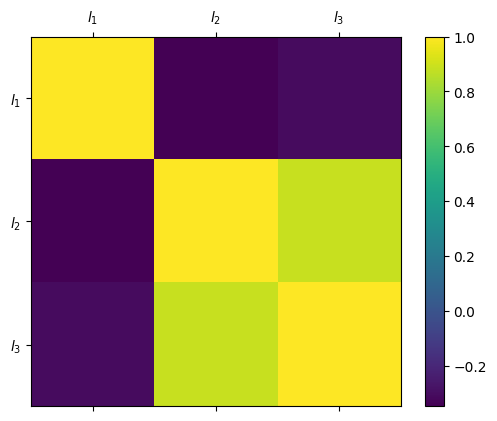

In [56]:
print(c)
f = plt.figure()
ax = f.add_subplot(111)
cax = ax.matshow(c, cmap='viridis')
cbar = f.colorbar(cax)
ax.set_xticklabels(['', '$l_1$','$l_2$','$l_3$'])
ax.set_yticklabels(['', '$l_1$','$l_2$','$l_3$'])

In [19]:
c12 = np.corrcoef(d1t, d2t)
c13 = np.corrcoef(d1t, d3t)
c23 = np.corrcoef(d2t, d3t)

In [27]:
c12,c13,c23

(array([[ 1.        , -0.34520451],
        [-0.34520451,  1.        ]]),
 array([[ 1.        , -0.30688117],
        [-0.30688117,  1.        ]]),
 array([[1.        , 0.88568174],
        [0.88568174, 1.        ]]))

In [17]:
d1t[np.newaxis, :]

array([[0.74203719, 0.74203717, 0.74203684, ..., 0.11432674, 0.09967106,
        0.08622895]])

In [28]:
d1t

array([[0.74203719, 0.74203717, 0.74203684, ..., 0.11432674, 0.09967106,
        0.08622895]])

In [33]:
dt = np.vstack((d1t,d2t,d3t))
dtt = np.vstack((d2t,d3t))

In [37]:
np.corrcoef([d1t,d2t,d3t])

ValueError: m has more than 2 dimensions

In [57]:
op = np.outer(d1t, d2t)

In [58]:
op.shape

(47536, 47536)

In [ ]:
samplesize=10
plt.imshow(op[::samplesize,::samplesize], interpolation='none')